In [37]:
# Libraries
import numpy as np

# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array , hstack
from pandas import read_csv
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
import time
import keras.backend as K

In [67]:
# add date information
def compute_weekend(row):
    if row['weekday'] > 4:
        return True
    else:
        return False

def prepare_df (data):

    #datetime(year, month, day, hour)
    a = datetime.datetime(2008, 12, 31, 1)

    numsteps = len(df)
    dateList = []
    for x in range (0, numsteps):
        dateList.append(a + datetime.timedelta(hours = x))
    start_date = "10/10/2009" # change when switching dataset

    data['date'] = dateList
    data.columns = ['slot', 'dow','hour', 'production', 'consumption', 'temp', 'wind', 'cloud', 'date']
    data.drop('slot', axis = 1, inplace = True)
    #data.drop('dow', axis = 1, inplace = True)
    #data.drop('hour', axis = 1, inplace = True)
    #data = data[['consumption', 'temp', 'wind', 'cloud', 'date']]
    data['consumption'] = data['consumption']*(-1)

    #df_indexed = df
    data.set_index('date', inplace=True)
    #df_indexed.tail()
    data['weekday']= data.index.weekday
    #data.set_index('date', inplace=True)
    data['is_weekend'] = data.apply (lambda row:compute_weekend(row), axis = 1)
    data = data[['consumption', 'temp', 'wind', 'cloud', 'hour', 'is_weekend']]
    return data

In [68]:
df = pd.read_csv("C:/Users/alexl/Desktop/MT/03_Data/Simulation_Alex/ProductionConsumption_first_11.csv", sep=",")
dataset = prepare_df(df)

In [69]:
train, test = dataset.iloc[:-3112], dataset.iloc[-3112:-12]

In [70]:
train.iloc[-5389:,: ]

,consumption,temp,wind,cloud,hour,is_weekend
date,,,,,,
2010-03-31 21:00:00,58.2904,3.9,3,0.625,21,False
2010-03-31 22:00:00,50.9333,3.9,3,1.000,22,False
2010-03-31 23:00:00,48.1341,4.2,4,1.000,23,False
2010-04-01 00:00:00,40.4206,4.0,3,0.750,0,False
2010-04-01 01:00:00,35.2484,4.1,5,0.750,1,False
...,...,...,...,...,...,...
2010-11-11 05:00:00,31.5381,19.0,4,0.625,5,False
2010-11-11 06:00:00,38.6563,20.4,3,1.000,6,False
2010-11-11 07:00:00,34.3562,19.4,5,0.875,7,False


In [71]:
# Data prep

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[:-3184], data[-3184:-12]
    # restructure into windows of daily data
    #train = array(split(train, len(train)/24))
    #test = array(split(test, len(test)/24))
    return train, test

In [72]:
def select_cols_to_drop(n_input, n_out, n_vars):
    drops = list()
    for i in range(n_out):
        lis = list()
        for step in range(n_vars-1):
            lis += [n_vars*n_input+step+1+n_vars*i]
        drops = drops + lis
    return drops

In [73]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=72, n_out=48, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define forecasting approach
n_in = 72
n_out = 24
n_vars = 6

# load dataset
values = train.values

encoder1 = LabelEncoder()
values[:,4] = encoder1.fit_transform(values[:,4])
encoder2 = LabelEncoder()
values[:,5] = encoder2.fit_transform(values[:,5])

# integer encode direction
values = values.astype('float32')
# convert col to [rows, columns]
cons = values[:, 1].reshape((len(values[:, 1]), 1))
weather = values[:,1:6]
# normalize features
scaler1 = MinMaxScaler()
scaled_consumption = scaler1.fit_transform(cons)
scaler2 = MinMaxScaler()
scaled_weather = scaler2.fit_transform(weather)

scaled = hstack((scaled_consumption, scaled_weather))

# frame as supervised learning
reframed = series_to_supervised(scaled, n_in, n_out)
# drop columns we don't want to predict

l_drop = select_cols_to_drop(n_in, n_out, n_vars)
print(l_drop)
reframed.drop(reframed.columns[l_drop], axis=1, inplace=True)
print(reframed.head(1))

[433, 434, 435, 436, 437, 439, 440, 441, 442, 443, 445, 446, 447, 448, 449, 451, 452, 453, 454, 455, 457, 458, 459, 460, 461, 463, 464, 465, 466, 467, 469, 470, 471, 472, 473, 475, 476, 477, 478, 479, 481, 482, 483, 484, 485, 487, 488, 489, 490, 491, 493, 494, 495, 496, 497, 499, 500, 501, 502, 503, 505, 506, 507, 508, 509, 511, 512, 513, 514, 515, 517, 518, 519, 520, 521, 523, 524, 525, 526, 527, 529, 530, 531, 532, 533, 535, 536, 537, 538, 539, 541, 542, 543, 544, 545, 547, 548, 549, 550, 551, 553, 554, 555, 556, 557, 559, 560, 561, 562, 563, 565, 566, 567, 568, 569, 571, 572, 573, 574, 575]
    var1(t-72)  var2(t-72)  var3(t-72)  var4(t-72)  var5(t-72)  var6(t-72)  \
72    0.506726    0.506726       0.125         1.0    0.043478         0.0   

    var1(t-71)  var2(t-71)  var3(t-71)  var4(t-71)  ...  var1(t+14)  \
72    0.506726    0.506726      0.0625         1.0  ...    0.504484   

    var1(t+15)  var1(t+16)  var1(t+17)  var1(t+18)  var1(t+19)  var1(t+20)  \
72    0.457399    0.4

In [74]:
#Input numbers
n_out = 24
n_in = 72

# split into train and test sets
values = reframed.values
train, val = values[:-5389, :], values[-5389:, :]
# split into input and outputs
train_X, train_y = train[:, :-n_out], train[:, -n_out:]
val_X, val_y = val[:, :-n_out], val[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, int(train_X.shape[1]/n_in)))
val_X = val_X.reshape((val_X.shape[0], n_in, int(val_X.shape[1]/n_in)))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(10845, 72, 6) (10845, 24) (5389, 72, 6) (5389, 24)


In [75]:
# Test set

# Define forecasting approach
n_in = 72
n_out = 24
n_vars = 6

# load dataset
values = test.values


values[:,4] = encoder1.transform(values[:,4])

values[:,5] = encoder2.transform(values[:,5])

# integer encode direction
values = values.astype('float32')
# convert col to [rows, columns]
cons = values[:, 1].reshape((len(values[:, 1]), 1))
weather = values[:,1:6]
# normalize features

scaled_consumption = scaler1.transform(cons)

scaled_weather = scaler2.transform(weather)

scaled = hstack((scaled_consumption, scaled_weather))

# frame as supervised learning
reframed = series_to_supervised(scaled, n_in, n_out)
# drop columns we don't want to predict

l_drop = select_cols_to_drop(n_in, n_out, n_vars)
reframed.drop(reframed.columns[l_drop], axis=1, inplace=True)
print(reframed.head(1))

    var1(t-72)  var2(t-72)  var3(t-72)  var4(t-72)  var5(t-72)  var6(t-72)  \
72    0.825112    0.825112      0.4375        0.75    0.434783         0.0   

    var1(t-71)  var2(t-71)  var3(t-71)  var4(t-71)  ...  var1(t+14)  \
72    0.804933    0.804933       0.375         1.0  ...    0.515695   

    var1(t+15)  var1(t+16)  var1(t+17)  var1(t+18)  var1(t+19)  var1(t+20)  \
72         0.5    0.506726    0.513453    0.502242    0.558296    0.598655   

    var1(t+21)  var1(t+22)  var1(t+23)  
72    0.656951    0.690583    0.699552  

[1 rows x 456 columns]


In [76]:
#Input numbers
n_out = 24
n_in = 72

# split into train and test sets
values = reframed.values

# split into input and outputs
test_X, test_y = values[:, :-n_out], values[:, -n_out:]


# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_in, int(test_X.shape[1]/n_in)))
print(test_X.shape, test_y.shape)

(3005, 72, 6) (3005, 24)


In [77]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def quantile_loss(y_true, y_pred, q):
    return np.max([q*(y_true - y_pred), (1-q)*(y_pred-y_true)], axis=0)

In [78]:
from keras.layers import Dropout
def build_model(neurons = 200):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(RepeatVector(48))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(1))

    return model

def build_model_one_layer(neurons = 200):
    model = Sequential()
    model.add(Dropout(0.3, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(72))
    #model.add(RepeatVector(24))
    #model.add(LSTM(neurons, activation='relu', return_sequences=True))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(24))

    return model

def fit_model(quantile, trainx, trainy, valx, valy, epoch = 200, batch_size = 700, verbose = 1):
    model.compile(loss=lambda y,f: tilted_loss(quantile,y,f), optimizer='adam')
    # fit network
    history = model.fit(trainx, trainy, epochs=epoch, batch_size = batch_size, validation_data=(valx, valy), verbose=verbose, shuffle=False)
    # make a prediction

    return model, history

def forecast(model, testx):
    yhat = model.predict(testx)
    return yhat
    
def extract_predictions(yhat, quantile):
    # design network
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))

    # invert scaling for forecast
    df_predictions = DataFrame()
    for i in range(yhat.shape[1]):

        inv_yhat = concatenate((yhat[:,i].reshape(yhat[:,i].shape[0], 1), test_X_reshaped[:, -3:]), axis=1)
        inv_yhat = scaler1.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        df_predictions['pred_hour_{}_quant_{}'.format(i, str(quantile)[-1])] = inv_yhat

  # invert scaling for actual
    df_actuals = DataFrame()

    for i in range(test_y.shape[1]):
        inv_y = concatenate((test_y[:,i].reshape(test_y[:,i].shape[0], 1), test_X_reshaped[:, -3:]), axis=1)
        inv_y = scaler1.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        df_actuals['actual_hour_{}_quant_{}'.format(i, str(quantile)[-1])] = inv_y

    acts.append(df_actuals)
    preds.append(df_predictions)

    return df_actuals, df_predictions

def get_accuracies(actual, predicted, quantile):
    accuracies = list()
    for i in range(actual.shape[1]):

        preds_hourly = np.asarray(predicted.iloc[:, i])
        acts_hourly = np.asarray(actual.iloc[:, i])
        accuracies.append(quantile_loss(acts_hourly, preds_hourly, 0.1).mean())

    df_accuracies['quantile_{}'.format(str(quantile)[-1])] = pd.Series(accuracies)

    return df_accuracies

Epoch 1/200
16/16 [==============================] - 12s 773ms/step - loss: 0.0569 - val_loss: 0.0490
Epoch 2/200
16/16 [==============================] - 14s 845ms/step - loss: 0.0547 - val_loss: 0.0593
Epoch 3/200
16/16 [==============================] - 14s 857ms/step - loss: 0.0472 - val_loss: 0.0325
Epoch 4/200
16/16 [==============================] - 12s 772ms/step - loss: 0.0411 - val_loss: 0.0408
Epoch 5/200
16/16 [==============================] - 13s 796ms/step - loss: 0.0334 - val_loss: 0.0253
Epoch 6/200
16/16 [==============================] - 14s 881ms/step - loss: 0.0330 - val_loss: 0.0255
Epoch 7/200
16/16 [==============================] - 14s 856ms/step - loss: 0.0267 - val_loss: 0.0249
Epoch 8/200
16/16 [==============================] - 4s 266ms/step - loss: 0.0250 - val_loss: 0.0243
Epoch 9/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0237 - val_loss: 0.0231
Epoch 10/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0234 -

16/16 [==============================] - 4s 242ms/step - loss: 0.0171 - val_loss: 0.0168
Epoch 159/200
16/16 [==============================] - 4s 248ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 160/200
16/16 [==============================] - 4s 246ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 161/200
16/16 [==============================] - 4s 241ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 162/200
16/16 [==============================] - 4s 239ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 163/200
16/16 [==============================] - 4s 243ms/step - loss: 0.0169 - val_loss: 0.0171
Epoch 164/200
16/16 [==============================] - 4s 246ms/step - loss: 0.0169 - val_loss: 0.0174
Epoch 165/200
16/16 [==============================] - 4s 239ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 166/200
16/16 [==============================] - 4s 238ms/step - loss: 0.0174 - val_loss: 0.0168ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0. - ETA: 0s - loss: 0.
Epoch 167/200
16/16 [===

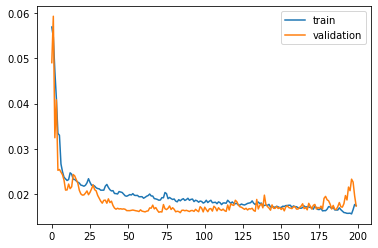

Epochs: 100, Quantile: 0.2, Accuracy: 0.01739262044429779
--- 912.0218710899353 seconds ---
Epoch 1/200
16/16 [==============================] - 5s 286ms/step - loss: 0.1158 - val_loss: 0.0727
Epoch 2/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0846 - val_loss: 0.0695
Epoch 3/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0643 - val_loss: 0.0475
Epoch 4/200
16/16 [==============================] - 4s 269ms/step - loss: 0.0662 - val_loss: 0.0511
Epoch 5/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0476 - val_loss: 0.0384
Epoch 6/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0482 - val_loss: 0.0580
Epoch 7/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0460 - val_loss: 0.0491
Epoch 8/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0404 - val_loss: 0.0445
Epoch 9/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0365 - val_loss: 0.0391

16/16 [==============================] - 4s 257ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 160/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0243 - val_loss: 0.0245
Epoch 161/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0253 - val_loss: 0.0247
Epoch 162/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0255 - val_loss: 0.0231
Epoch 163/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0243 - val_loss: 0.0229
Epoch 164/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0245 - val_loss: 0.0250
Epoch 165/200
16/16 [==============================] - 4s 261ms/step - loss: 0.0245 - val_loss: 0.0229
Epoch 166/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0237 - val_loss: 0.0231
Epoch 167/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0241 - val_loss: 0.0231
Epoch 168/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0242 - v

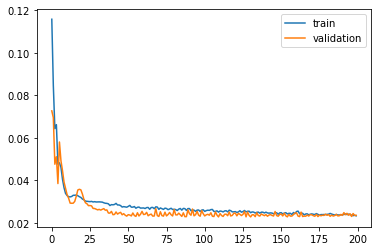

Epochs: 100, Quantile: 0.4, Accuracy: 0.023505643010139465
--- 1790.7503998279572 seconds ---
Epoch 1/200
16/16 [==============================] - 5s 283ms/step - loss: 0.1656 - val_loss: 0.1032
Epoch 2/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0955 - val_loss: 0.0545
Epoch 3/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0655 - val_loss: 0.0439
Epoch 4/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0570 - val_loss: 0.0489
Epoch 5/200
16/16 [==============================] - 4s 258ms/step - loss: 0.0467 - val_loss: 0.0629
Epoch 6/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0408 - val_loss: 0.0443
Epoch 7/200
16/16 [==============================] - 4s 249ms/step - loss: 0.0359 - val_loss: 0.0380
Epoch 8/200
16/16 [==============================] - 4s 251ms/step - loss: 0.0340 - val_loss: 0.0328
Epoch 9/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0330 - val_loss: 0.03

Epoch 80/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0266 - val_loss: 0.0267
Epoch 81/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0271 - val_loss: 0.0266
Epoch 82/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0267 - val_loss: 0.0265
Epoch 83/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 84/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0264 - val_loss: 0.0252
Epoch 85/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0266 - val_loss: 0.0263
Epoch 86/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0273 - val_loss: 0.0269
Epoch 87/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0264 - val_loss: 0.0247
Epoch 88/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0266 - val_loss: 0.0264
Epoch 89/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0273

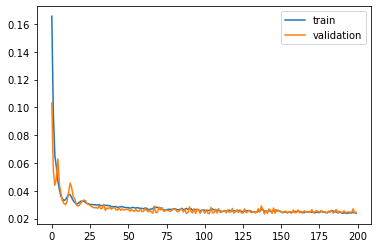

Epochs: 100, Quantile: 0.6, Accuracy: 0.024424508213996887
--- 2652.6745252609253 seconds ---
Epoch 1/200
16/16 [==============================] - 5s 287ms/step - loss: 0.2421 - val_loss: 0.1094
Epoch 2/200
16/16 [==============================] - 4s 266ms/step - loss: 0.0712 - val_loss: 0.0475
Epoch 3/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0625 - val_loss: 0.0498
Epoch 4/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0492 - val_loss: 0.0315
Epoch 5/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0449 - val_loss: 0.0515
Epoch 6/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0424 - val_loss: 0.0308
Epoch 7/200
16/16 [==============================] - 4s 261ms/step - loss: 0.0321 - val_loss: 0.0358
Epoch 8/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0287 - val_loss: 0.0257
Epoch 9/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0288 - val_loss: 0.03

16/16 [==============================] - 4s 252ms/step - loss: 0.0182 - val_loss: 0.0206
Epoch 160/200
16/16 [==============================] - 4s 265ms/step - loss: 0.0180 - val_loss: 0.0185
Epoch 161/200
16/16 [==============================] - 4s 267ms/step - loss: 0.0181 - val_loss: 0.0204
Epoch 162/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0180 - val_loss: 0.0191
Epoch 163/200
16/16 [==============================] - 4s 262ms/step - loss: 0.0176 - val_loss: 0.0179
Epoch 164/200
16/16 [==============================] - 4s 274ms/step - loss: 0.0178 - val_loss: 0.0199
Epoch 165/200
16/16 [==============================] - 4s 265ms/step - loss: 0.0182 - val_loss: 0.0186
Epoch 166/200
16/16 [==============================] - 4s 262ms/step - loss: 0.0181 - val_loss: 0.0194
Epoch 167/200
16/16 [==============================] - 4s 274ms/step - loss: 0.0184 - val_loss: 0.0191
Epoch 168/200
16/16 [==============================] - 4s 261ms/step - loss: 0.0182 - v

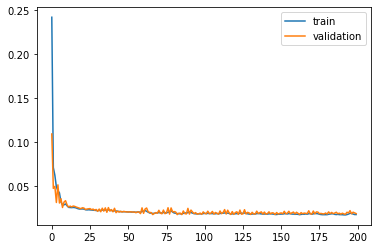

Epochs: 100, Quantile: 0.8, Accuracy: 0.01881629042327404
--- 3528.6272099018097 seconds ---
--- 3528.6282069683075 seconds ---


In [79]:
import time
start_time = time.time()

from numpy import concatenate
quantiles = [0.2, 0.4, 0.6, 0.8]
acts = list()
preds = list()
df_accuracies = DataFrame()
histories = list()
epochs = 200


for quantile in quantiles:
    model = build_model_one_layer()
    model, history = fit_model(quantile, train_X, train_y, val_X, val_y, verbose = 1)
    score = history.history.get('val_loss')[-1]
    histories.append(history)

    # Plot train and validation error
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    print('Epochs: {}, Quantile: {}, Accuracy: {}'.format(i, quantile, score))
    print("--- %s seconds ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
# 100
(0.02389+ 0.02395)/2

0.02392

In [15]:
# 200: 
(0.020327+ 0.019779)/2

0.020053

In [16]:
# 500: 
(0.02068+ 0.0192836)/2

0.0199818

In [17]:
#1000: 
(0.02314+ 0.020377)/2

0.0217585

In [18]:
# select 200!

In [ ]:
# Tune batch size

In [59]:
quantiles = [0.3, 0.6]
acts = list()
preds = list()
df_accuracies = DataFrame()
histories = list()
bs_grid = [723]

for bs in bs_grid:
    for quantile in quantiles:
        model = build_model()
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y,epoch = 10, batch_size = bs, verbose = 1)
        score = history.history.get('val_loss')[-1]
        histories.append(history)
        print('Batch size: {}, Quantile: {}, Accuracy: {}'.format(bs, quantile, score))
        print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/10
15/15 [==============================] - 14s 914ms/step - loss: 0.0557 - val_loss: 0.0684
Epoch 2/10
15/15 [==============================] - 14s 921ms/step - loss: 0.0540 - val_loss: 0.0492
Epoch 3/10
15/15 [==============================] - 13s 890ms/step - loss: 0.0575 - val_loss: 0.0436
Epoch 4/10
15/15 [==============================] - 13s 895ms/step - loss: 0.0472 - val_loss: 0.0516
Epoch 5/10
15/15 [==============================] - 13s 900ms/step - loss: 0.0382 - val_loss: 0.0467
Epoch 6/10
15/15 [==============================] - 13s 897ms/step - loss: 0.0339 - val_loss: 0.0422
Epoch 7/10
15/15 [==============================] - 14s 958ms/step - loss: 0.0318 - val_loss: 0.0351
Epoch 8/10
15/15 [==============================] - 14s 941ms/step - loss: 0.0297 - val_loss: 0.0323
Epoch 9/10
15/15 [==============================] - 14s 930ms/step - loss: 0.0290 - val_loss: 0.0362
Epoch 10/10
15/15 [==============================] - 14s 962ms/step - loss: 0.0327 - val_lo

In [36]:
#bs_grid: 1
(0.0669266+0.10724245)/2

0.087084525

In [39]:
#bs_grid: 2
(0.066937+0.1223826)/2

0.09465979999999999

In [38]:
#bs_grid:4
(0.0585146+0.129394695)/2

0.0939546475

In [40]:
#bs_grid:8
(0.06369557976722717+0.081381656229496)/2

0.07253861799836159

In [45]:
#bs_grid:241
(0.041346460580825806+0.04640651121735573)/2

0.04387648589909077

In [50]:
#bs_grid:723
(0.030573565512895584+0.030573565512895584)/2

0.030573565512895584

In [51]:
(0.0351857990026474+0.036446742713451385)/2

0.03581627085804939

In [54]:
# bs2169
(0.036737628281116486+0.04282495006918907)/2

0.03978128917515278

In [56]:
#bs 800
(0.03623247519135475+0.05469324067234993)/2

0.04546285793185234

In [58]:
#bs = 700
(0.03185953572392464+0.037934307008981705)/2

0.03489692136645317

In [ ]:
# -> select bs = 700

In [ ]:
# Tune number of neurons

In [18]:
import time
start_time = time.time()

quantiles = [0.3, 0.6]
acts = list()
preds = list()
df_accuracies = DataFrame()
model_hist = list()
neurons_grid = [24, 47, 72, 148]

for neuron in neurons_grid:
    for quantile in quantiles:
        model = build_model(neurons = neuron)
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y, batch_size = 700, verbose = 1)
        score = history.history.get('val_loss')[-1]
        model_hist.append(history)
        print('Neurons: {}, Quantile: {}, Accuracy: {}'.format(neuron, quantile, score))
        print("--- %s seconds ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
16/16 [==============================] - 2s 131ms/step - loss: 0.0823 - val_loss: 0.0564
Epoch 2/200
16/16 [==============================] - 2s 104ms/step - loss: 0.0685 - val_loss: 0.0712
Epoch 3/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0501 - val_loss: 0.0444
Epoch 4/200
16/16 [==============================] - 2s 102ms/step - loss: 0.0531 - val_loss: 0.0507
Epoch 5/200
16/16 [==============================] - 2s 108ms/step - loss: 0.0380 - val_loss: 0.0390
Epoch 6/200
16/16 [==============================] - 2s 106ms/step - loss: 0.0379 - val_loss: 0.0422
Epoch 7/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0355 - val_loss: 0.0385
Epoch 8/200
16/16 [==============================] - 2s 104ms/step - loss: 0.0329 - val_loss: 0.0348
Epoch 9/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0307 - val_loss: 0.0338
Epoch 10/200
16/16 [==============================] - 2s 103ms/step - loss: 0.0295 - val_lo

16/16 [==============================] - 2s 99ms/step - loss: 0.0168 - val_loss: 0.0184
Epoch 162/200
16/16 [==============================] - 2s 97ms/step - loss: 0.0168 - val_loss: 0.0182
Epoch 163/200
16/16 [==============================] - 2s 98ms/step - loss: 0.0165 - val_loss: 0.0181
Epoch 164/200
16/16 [==============================] - 2s 99ms/step - loss: 0.0166 - val_loss: 0.0184
Epoch 165/200
16/16 [==============================] - 1s 93ms/step - loss: 0.0170 - val_loss: 0.0183
Epoch 166/200
16/16 [==============================] - 1s 93ms/step - loss: 0.0167 - val_loss: 0.0181
Epoch 167/200
16/16 [==============================] - 2s 104ms/step - loss: 0.0166 - val_loss: 0.0186
Epoch 168/200
16/16 [==============================] - 2s 104ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 169/200
16/16 [==============================] - 2s 103ms/step - loss: 0.0171 - val_loss: 0.0182
Epoch 170/200
16/16 [==============================] - 2s 100ms/step - loss: 0.0168 - val_los

16/16 [==============================] - 2s 100ms/step - loss: 0.0215 - val_loss: 0.0212
Epoch 118/200
16/16 [==============================] - 2s 104ms/step - loss: 0.0209 - val_loss: 0.0214
Epoch 119/200
16/16 [==============================] - 2s 106ms/step - loss: 0.0209 - val_loss: 0.0209
Epoch 120/200
16/16 [==============================] - 2s 102ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 121/200
16/16 [==============================] - 2s 102ms/step - loss: 0.0208 - val_loss: 0.0207
Epoch 122/200
16/16 [==============================] - 2s 100ms/step - loss: 0.0206 - val_loss: 0.0213
Epoch 123/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 124/200
16/16 [==============================] - 2s 114ms/step - loss: 0.0204 - val_loss: 0.0212
Epoch 125/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0206 - val_loss: 0.0205ETA: 0s - los
Epoch 126/200
16/16 [==============================] - 2s 112ms/step - los

16/16 [==============================] - 3s 173ms/step - loss: 0.0196 - val_loss: 0.0213
Epoch 75/200
16/16 [==============================] - 3s 162ms/step - loss: 0.0195 - val_loss: 0.0212
Epoch 76/200
16/16 [==============================] - 3s 161ms/step - loss: 0.0197 - val_loss: 0.0212
Epoch 77/200
16/16 [==============================] - 3s 163ms/step - loss: 0.0196 - val_loss: 0.0213
Epoch 78/200
16/16 [==============================] - 3s 168ms/step - loss: 0.0195 - val_loss: 0.0242
Epoch 79/200
16/16 [==============================] - 3s 169ms/step - loss: 0.0214 - val_loss: 0.0229
Epoch 80/200
16/16 [==============================] - 3s 167ms/step - loss: 0.0216 - val_loss: 0.0233
Epoch 81/200
16/16 [==============================] - 3s 163ms/step - loss: 0.0225 - val_loss: 0.0236
Epoch 82/200
16/16 [==============================] - 3s 162ms/step - loss: 0.0227 - val_loss: 0.0221
Epoch 83/200
16/16 [==============================] - 3s 163ms/step - loss: 0.0213 - val_loss: 

Epoch 154/200
16/16 [==============================] - 3s 179ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 155/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0168 - val_loss: 0.0182
Epoch 156/200
16/16 [==============================] - 3s 160ms/step - loss: 0.0172 - val_loss: 0.0179
Epoch 157/200
16/16 [==============================] - 3s 157ms/step - loss: 0.0171 - val_loss: 0.0184
Epoch 158/200
16/16 [==============================] - 3s 159ms/step - loss: 0.0175 - val_loss: 0.0180
Epoch 159/200
16/16 [==============================] - 3s 165ms/step - loss: 0.0175 - val_loss: 0.0187
Epoch 160/200
16/16 [==============================] - 3s 163ms/step - loss: 0.0179 - val_loss: 0.0180
Epoch 161/200
16/16 [==============================] - 3s 160ms/step - loss: 0.0174 - val_loss: 0.0186
Epoch 162/200
16/16 [==============================] - 3s 160ms/step - loss: 0.0172 - val_loss: 0.0178
Epoch 163/200
16/16 [==============================] - 3s 160ms/step - lo

16/16 [==============================] - 3s 174ms/step - loss: 0.0277 - val_loss: 0.0287
Epoch 34/200
16/16 [==============================] - 3s 170ms/step - loss: 0.0273 - val_loss: 0.0291
Epoch 35/200
16/16 [==============================] - 3s 167ms/step - loss: 0.0266 - val_loss: 0.0293
Epoch 36/200
16/16 [==============================] - 3s 167ms/step - loss: 0.0258 - val_loss: 0.0288
Epoch 37/200
16/16 [==============================] - 3s 171ms/step - loss: 0.0253 - val_loss: 0.0283
Epoch 38/200
16/16 [==============================] - 3s 178ms/step - loss: 0.0249 - val_loss: 0.0277
Epoch 39/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0249 - val_loss: 0.0276
Epoch 40/200
16/16 [==============================] - 3s 167ms/step - loss: 0.0249 - val_loss: 0.0277
Epoch 41/200
16/16 [==============================] - 3s 166ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 42/200
16/16 [==============================] - 3s 168ms/step - loss: 0.0245 - val_loss: 

16/16 [==============================] - 3s 170ms/step - loss: 0.0175 - val_loss: 0.0217
Epoch 193/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0173 - val_loss: 0.0212
Epoch 194/200
16/16 [==============================] - 3s 172ms/step - loss: 0.0175 - val_loss: 0.0213
Epoch 195/200
16/16 [==============================] - 3s 166ms/step - loss: 0.0173 - val_loss: 0.0224
Epoch 196/200
16/16 [==============================] - 3s 168ms/step - loss: 0.0176 - val_loss: 0.0222
Epoch 197/200
16/16 [==============================] - 3s 168ms/step - loss: 0.0172 - val_loss: 0.0219
Epoch 198/200
16/16 [==============================] - 3s 183ms/step - loss: 0.0174 - val_loss: 0.0227
Epoch 199/200
16/16 [==============================] - 3s 178ms/step - loss: 0.0174 - val_loss: 0.0238
Epoch 200/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0184 - val_loss: 0.0248
Neurons: 47, Quantile: 0.6, Accuracy: 0.02484528347849846
--- 1856.6281204223633 second

Epoch 151/200
16/16 [==============================] - 4s 265ms/step - loss: 0.0161 - val_loss: 0.0187
Epoch 152/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0160 - val_loss: 0.0185
Epoch 153/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0164 - val_loss: 0.0201
Epoch 154/200
16/16 [==============================] - 4s 269ms/step - loss: 0.0162 - val_loss: 0.0193
Epoch 155/200
16/16 [==============================] - 4s 265ms/step - loss: 0.0160 - val_loss: 0.0191
Epoch 156/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 157/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0155 - val_loss: 0.0190
Epoch 158/200
16/16 [==============================] - 4s 270ms/step - loss: 0.0157 - val_loss: 0.0185
Epoch 159/200
16/16 [==============================] - 4s 267ms/step - loss: 0.0159 - val_loss: 0.0197
Epoch 160/200
16/16 [==============================] - 4s 258ms/step - lo

16/16 [==============================] - 4s 266ms/step - loss: 0.0271 - val_loss: 0.0291
Epoch 31/200
16/16 [==============================] - 4s 264ms/step - loss: 0.0280 - val_loss: 0.0286
Epoch 32/200
16/16 [==============================] - 4s 276ms/step - loss: 0.0285 - val_loss: 0.0293
Epoch 33/200
16/16 [==============================] - 4s 274ms/step - loss: 0.0281 - val_loss: 0.0308
Epoch 34/200
16/16 [==============================] - 4s 261ms/step - loss: 0.0271 - val_loss: 0.0311
Epoch 35/200
16/16 [==============================] - 4s 258ms/step - loss: 0.0261 - val_loss: 0.0297
Epoch 36/200
16/16 [==============================] - 4s 271ms/step - loss: 0.0254 - val_loss: 0.0285
Epoch 37/200
16/16 [==============================] - 4s 266ms/step - loss: 0.0249 - val_loss: 0.0276
Epoch 38/200
16/16 [==============================] - 4s 261ms/step - loss: 0.0247 - val_loss: 0.0272
Epoch 39/200
16/16 [==============================] - 4s 266ms/step - loss: 0.0247 - val_loss: 

16/16 [==============================] - 4s 274ms/step - loss: 0.0169 - val_loss: 0.0230
Epoch 190/200
16/16 [==============================] - 4s 265ms/step - loss: 0.0175 - val_loss: 0.0217
Epoch 191/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0173 - val_loss: 0.0204
Epoch 192/200
16/16 [==============================] - 4s 268ms/step - loss: 0.0177 - val_loss: 0.0207
Epoch 193/200
16/16 [==============================] - 4s 268ms/step - loss: 0.0183 - val_loss: 0.0209
Epoch 194/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0173 - val_loss: 0.0203
Epoch 195/200
16/16 [==============================] - 4s 270ms/step - loss: 0.0171 - val_loss: 0.0204
Epoch 196/200
16/16 [==============================] - 4s 277ms/step - loss: 0.0171 - val_loss: 0.0219
Epoch 197/200
16/16 [==============================] - 4s 267ms/step - loss: 0.0171 - val_loss: 0.0208
Epoch 198/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0169 - v

Epoch 148/200
16/16 [==============================] - 9s 573ms/step - loss: 0.0158 - val_loss: 0.0182
Epoch 149/200
16/16 [==============================] - 9s 566ms/step - loss: 0.0157 - val_loss: 0.0179
Epoch 150/200
16/16 [==============================] - 9s 548ms/step - loss: 0.0160 - val_loss: 0.0177
Epoch 151/200
16/16 [==============================] - 9s 553ms/step - loss: 0.0157 - val_loss: 0.0180
Epoch 152/200
16/16 [==============================] - 9s 567ms/step - loss: 0.0160 - val_loss: 0.0194
Epoch 153/200
16/16 [==============================] - 9s 559ms/step - loss: 0.0160 - val_loss: 0.0183
Epoch 154/200
16/16 [==============================] - 9s 576ms/step - loss: 0.0156 - val_loss: 0.0182
Epoch 155/200
16/16 [==============================] - 9s 575ms/step - loss: 0.0156 - val_loss: 0.0183
Epoch 156/200
16/16 [==============================] - 9s 581ms/step - loss: 0.0162 - val_loss: 0.0181
Epoch 157/200
16/16 [==============================] - 9s 560ms/step - lo

Epoch 27/200
16/16 [==============================] - 9s 540ms/step - loss: 0.0297 - val_loss: 0.0354
Epoch 28/200
16/16 [==============================] - 9s 540ms/step - loss: 0.0280 - val_loss: 0.0309
Epoch 29/200
16/16 [==============================] - 9s 552ms/step - loss: 0.0271 - val_loss: 0.0298
Epoch 30/200
16/16 [==============================] - 9s 574ms/step - loss: 0.0269 - val_loss: 0.0300
Epoch 31/200
16/16 [==============================] - 9s 545ms/step - loss: 0.0273 - val_loss: 0.0304
Epoch 32/200
16/16 [==============================] - 9s 562ms/step - loss: 0.0281 - val_loss: 0.0297
Epoch 33/200
16/16 [==============================] - 9s 548ms/step - loss: 0.0294 - val_loss: 0.0295
Epoch 34/200
16/16 [==============================] - 9s 552ms/step - loss: 0.0302 - val_loss: 0.0325
Epoch 35/200
16/16 [==============================] - 9s 556ms/step - loss: 0.0294 - val_loss: 0.0332
Epoch 36/200
16/16 [==============================] - 9s 538ms/step - loss: 0.0278

16/16 [==============================] - 9s 566ms/step - loss: 0.0181 - val_loss: 0.0202
Epoch 187/200
16/16 [==============================] - 10s 607ms/step - loss: 0.0176 - val_loss: 0.0209
Epoch 188/200
16/16 [==============================] - 9s 573ms/step - loss: 0.0177 - val_loss: 0.0203
Epoch 189/200
16/16 [==============================] - 10s 596ms/step - loss: 0.0171 - val_loss: 0.0220
Epoch 190/200
16/16 [==============================] - 9s 555ms/step - loss: 0.0187 - val_loss: 0.0224
Epoch 191/200
16/16 [==============================] - 10s 601ms/step - loss: 0.0177 - val_loss: 0.0231
Epoch 192/200
16/16 [==============================] - 10s 610ms/step - loss: 0.0174 - val_loss: 0.0204
Epoch 193/200
16/16 [==============================] - 10s 601ms/step - loss: 0.0179 - val_loss: 0.0214
Epoch 194/200
16/16 [==============================] - 10s 638ms/step - loss: 0.0185 - val_loss: 0.0205
Epoch 195/200
16/16 [==============================] - 9s 543ms/step - loss: 0.01

In [ ]:
# 24 neurons wins

In [ ]:
# Plot trining process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
# LSTM only one layer
def build_model_one_layer(neurons = 200):
    model = Sequential()
    model.add(LSTM(72, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(RepeatVector(24))
    #model.add(LSTM(neurons, activation='relu', return_sequences=True))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(48))

    return model

import time
start_time = time.time()

quantiles = [0.3, 0.6]
acts = list()
preds = list()
df_accuracies = DataFrame()
model_hist = list()
neurons_grid = [24, 47, 72, 148, 200]
#select 72 neurons
for neuron in neurons_grid:
    for quantile in quantiles:
        model = build_model_one_layer(neurons = neuron)
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y, batch_size = 700, verbose = 1)
        score = history.history.get('val_loss')[-1]
        model_hist.append(history)
        print('Neurons: {}, Quantile: {}, Accuracy: {}'.format(neuron, quantile, score))
        print("--- %s seconds ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
16/16 [==============================] - 2s 134ms/step - loss: 0.1168 - val_loss: 0.1039
Epoch 2/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0790 - val_loss: 0.0588
Epoch 3/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0644 - val_loss: 0.0603
Epoch 4/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0482 - val_loss: 0.0383
Epoch 5/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0458 - val_loss: 0.0377
Epoch 6/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 7/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0288 - val_loss: 0.0318
Epoch 8/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0275 - val_loss: 0.0310
Epoch 9/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0269 - val_loss: 0.0300
Epoch 10/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0265 - val_lo

16/16 [==============================] - 2s 110ms/step - loss: 0.0214 - val_loss: 0.0226
Epoch 81/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0214 - val_loss: 0.0226
Epoch 82/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0214 - val_loss: 0.0226
Epoch 83/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0215 - val_loss: 0.0226
Epoch 84/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0215 - val_loss: 0.0225
Epoch 85/200
16/16 [==============================] - 2s 106ms/step - loss: 0.0215 - val_loss: 0.0225ETA: 0s - loss: 0.02
Epoch 86/200
16/16 [==============================] - 2s 108ms/step - loss: 0.0215 - val_loss: 0.0225
Epoch 87/200
16/16 [==============================] - 2s 107ms/step - loss: 0.0215 - val_loss: 0.0225
Epoch 88/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0215 - val_loss: 0.0225 ETA: 0s - loss: - ETA: 0s - loss: 0.02
Epoch 89/200
16/16 [================

16/16 [==============================] - 2s 111ms/step - loss: 0.0204 - val_loss: 0.0217
Epoch 156/200
16/16 [==============================] - 2s 108ms/step - loss: 0.0203 - val_loss: 0.0217
Epoch 157/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0203 - val_loss: 0.0216
Epoch 158/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0203 - val_loss: 0.0216
Epoch 159/200
16/16 [==============================] - 2s 106ms/step - loss: 0.0203 - val_loss: 0.0216TA: 0s - loss: 0.0 - ETA: 0s - loss: 0.
Epoch 160/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0203 - val_loss: 0.0216
Epoch 161/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0203 - val_loss: 0.02160s - loss: 0. - ETA: 0s - loss: 0.02
Epoch 162/200
16/16 [==============================] - 2s 108ms/step - loss: 0.0203 - val_loss: 0.0216A: 0s - loss: 0
Epoch 163/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0203 - val_loss: 0.02

16/16 [==============================] - 2s 113ms/step - loss: 0.0235 - val_loss: 0.0246
Epoch 104/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0235 - val_loss: 0.0246
Epoch 105/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0234 - val_loss: 0.0245
Epoch 106/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0234 - val_loss: 0.0246 0s - los
Epoch 107/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0234 - val_loss: 0.0245
Epoch 108/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0234 - val_loss: 0.0245A: 0s - loss:
Epoch 109/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0233 - val_loss: 0.0245
Epoch 110/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0233 - val_loss: 0.0245
Epoch 111/200
16/16 [==============================] - 2s 114ms/step - loss: 0.0233 - val_loss: 0.0244
Epoch 112/200
16/16 [==============================] - 2s 112ms/s

16/16 [==============================] - 2s 115ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 181/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 182/200
16/16 [==============================] - 2s 108ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 183/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 184/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 185/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 186/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 187/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0223 - val_loss: 0.0241
Epoch 188/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0223 - val_loss: 0.0241
Epoch 189/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0223 - v

Epoch 59/200
16/16 [==============================] - 3s 179ms/step - loss: 0.0212 - val_loss: 0.0222
Epoch 60/200
16/16 [==============================] - 3s 188ms/step - loss: 0.0212 - val_loss: 0.0222
Epoch 61/200
16/16 [==============================] - 3s 187ms/step - loss: 0.0212 - val_loss: 0.0222
Epoch 62/200
16/16 [==============================] - 3s 181ms/step - loss: 0.0212 - val_loss: 0.0223
Epoch 63/200
16/16 [==============================] - 3s 179ms/step - loss: 0.0213 - val_loss: 0.0223
Epoch 64/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0213 - val_loss: 0.0223
Epoch 65/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0214 - val_loss: 0.0222
Epoch 66/200
16/16 [==============================] - 3s 178ms/step - loss: 0.0213 - val_loss: 0.0222
Epoch 67/200
16/16 [==============================] - 3s 182ms/step - loss: 0.0213 - val_loss: 0.0222
Epoch 68/200
16/16 [==============================] - 3s 180ms/step - loss: 0.0212

Epoch 139/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0202 - val_loss: 0.0218
Epoch 140/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0199 - val_loss: 0.0215
Epoch 141/200
16/16 [==============================] - 3s 184ms/step - loss: 0.0200 - val_loss: 0.0218
Epoch 142/200
16/16 [==============================] - 3s 180ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 143/200
16/16 [==============================] - 3s 177ms/step - loss: 0.0198 - val_loss: 0.0216
Epoch 144/200
16/16 [==============================] - 3s 177ms/step - loss: 0.0200 - val_loss: 0.0218
Epoch 145/200
16/16 [==============================] - 3s 182ms/step - loss: 0.0200 - val_loss: 0.0217
Epoch 146/200
16/16 [==============================] - 3s 183ms/step - loss: 0.0197 - val_loss: 0.0215
Epoch 147/200
16/16 [==============================] - 3s 181ms/step - loss: 0.0200 - val_loss: 0.0218
Epoch 148/200
16/16 [==============================] - 3s 178ms/step - lo

Epoch 18/200
16/16 [==============================] - 3s 169ms/step - loss: 0.0312 - val_loss: 0.0338
Epoch 19/200
16/16 [==============================] - 3s 168ms/step - loss: 0.0301 - val_loss: 0.0333
Epoch 20/200
16/16 [==============================] - 3s 172ms/step - loss: 0.0291 - val_loss: 0.0321
Epoch 21/200
16/16 [==============================] - 3s 177ms/step - loss: 0.0284 - val_loss: 0.0310
Epoch 22/200
16/16 [==============================] - 3s 175ms/step - loss: 0.0279 - val_loss: 0.0302
Epoch 23/200
16/16 [==============================] - 3s 169ms/step - loss: 0.0277 - val_loss: 0.0297
Epoch 24/200
16/16 [==============================] - 3s 168ms/step - loss: 0.0276 - val_loss: 0.0294
Epoch 25/200
16/16 [==============================] - 3s 170ms/step - loss: 0.0277 - val_loss: 0.0291
Epoch 26/200
16/16 [==============================] - 3s 177ms/step - loss: 0.0278 - val_loss: 0.0290
Epoch 27/200
16/16 [==============================] - 3s 175ms/step - loss: 0.0279

16/16 [==============================] - 3s 169ms/step - loss: 0.0224 - val_loss: 0.0249
Epoch 178/200
16/16 [==============================] - 3s 173ms/step - loss: 0.0230 - val_loss: 0.0252
Epoch 179/200
16/16 [==============================] - 3s 177ms/step - loss: 0.0220 - val_loss: 0.0244
Epoch 180/200
16/16 [==============================] - 3s 176ms/step - loss: 0.0225 - val_loss: 0.0247
Epoch 181/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0222 - val_loss: 0.0248
Epoch 182/200
16/16 [==============================] - 3s 176ms/step - loss: 0.0227 - val_loss: 0.0254
Epoch 183/200
16/16 [==============================] - 3s 174ms/step - loss: 0.0222 - val_loss: 0.0249
Epoch 184/200
16/16 [==============================] - 3s 180ms/step - loss: 0.0224 - val_loss: 0.0252
Epoch 185/200
16/16 [==============================] - 3s 178ms/step - loss: 0.0219 - val_loss: 0.0242
Epoch 186/200
16/16 [==============================] - 3s 173ms/step - loss: 0.0220 - v

Epoch 136/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 137/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0198 - val_loss: 0.0213
Epoch 138/200
16/16 [==============================] - 4s 254ms/step - loss: 0.0196 - val_loss: 0.0213
Epoch 139/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0198 - val_loss: 0.0214
Epoch 140/200
16/16 [==============================] - 4s 264ms/step - loss: 0.0198 - val_loss: 0.0214
Epoch 141/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0197 - val_loss: 0.0213
Epoch 142/200
16/16 [==============================] - 4s 250ms/step - loss: 0.0197 - val_loss: 0.0215
Epoch 143/200
16/16 [==============================] - 4s 250ms/step - loss: 0.0197 - val_loss: 0.0217
Epoch 144/200
16/16 [==============================] - 4s 260ms/step - loss: 0.0198 - val_loss: 0.0214
Epoch 145/200
16/16 [==============================] - 4s 260ms/step - lo

Epoch 15/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0309 - val_loss: 0.0322A: 0s - loss: 0.03
Epoch 16/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0310 - val_loss: 0.0328
Epoch 17/200
16/16 [==============================] - 4s 264ms/step - loss: 0.0306 - val_loss: 0.0330
Epoch 18/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0300 - val_loss: 0.0325
Epoch 19/200
16/16 [==============================] - 4s 250ms/step - loss: 0.0293 - val_loss: 0.0317
Epoch 20/200
16/16 [==============================] - 4s 251ms/step - loss: 0.0287 - val_loss: 0.0310
Epoch 21/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0284 - val_loss: 0.0304
Epoch 22/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 23/200
16/16 [==============================] - 4s 247ms/step - loss: 0.0282 - val_loss: 0.0297
Epoch 24/200
16/16 [==============================] - 4s 252ms/s

Epoch 173/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0225 - val_loss: 0.0246
Epoch 174/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0221 - val_loss: 0.0254
Epoch 175/200
16/16 [==============================] - 4s 255ms/step - loss: 0.0220 - val_loss: 0.0249
Epoch 176/200
16/16 [==============================] - 4s 253ms/step - loss: 0.0225 - val_loss: 0.0254
Epoch 177/200
16/16 [==============================] - 4s 261ms/step - loss: 0.0219 - val_loss: 0.0246
Epoch 178/200
16/16 [==============================] - 4s 256ms/step - loss: 0.0214 - val_loss: 0.0248
Epoch 179/200
16/16 [==============================] - 4s 252ms/step - loss: 0.0218 - val_loss: 0.0255
Epoch 180/200
16/16 [==============================] - 4s 247ms/step - loss: 0.0220 - val_loss: 0.0253
Epoch 181/200
16/16 [==============================] - 4s 250ms/step - loss: 0.0213 - val_loss: 0.0251
Epoch 182/200
16/16 [==============================] - 4s 257ms/step - lo

Epoch 52/200
16/16 [==============================] - 9s 554ms/step - loss: 0.0217 - val_loss: 0.0224
Epoch 53/200
16/16 [==============================] - 8s 511ms/step - loss: 0.0218 - val_loss: 0.0221
Epoch 54/200
16/16 [==============================] - 9s 574ms/step - loss: 0.0215 - val_loss: 0.0224
Epoch 55/200
16/16 [==============================] - 8s 518ms/step - loss: 0.0216 - val_loss: 0.0222
Epoch 56/200
16/16 [==============================] - 9s 557ms/step - loss: 0.0216 - val_loss: 0.0222
Epoch 57/200
16/16 [==============================] - 8s 527ms/step - loss: 0.0215 - val_loss: 0.0220
Epoch 58/200
16/16 [==============================] - 8s 521ms/step - loss: 0.0214 - val_loss: 0.0221
Epoch 59/200
16/16 [==============================] - 9s 563ms/step - loss: 0.0214 - val_loss: 0.0219
Epoch 60/200
16/16 [==============================] - 9s 541ms/step - loss: 0.0214 - val_loss: 0.0218
Epoch 61/200
16/16 [==============================] - 9s 556ms/step - loss: 0.0211

Epoch 132/200
16/16 [==============================] - 9s 539ms/step - loss: 0.0199 - val_loss: 0.0221
Epoch 133/200
16/16 [==============================] - 8s 526ms/step - loss: 0.0199 - val_loss: 0.0235
Epoch 134/200
16/16 [==============================] - 9s 561ms/step - loss: 0.0210 - val_loss: 0.0227
Epoch 135/200
16/16 [==============================] - 9s 536ms/step - loss: 0.0206 - val_loss: 0.0229
Epoch 136/200
16/16 [==============================] - 8s 525ms/step - loss: 0.0205 - val_loss: 0.0217
Epoch 137/200
16/16 [==============================] - 9s 549ms/step - loss: 0.0203 - val_loss: 0.0224
Epoch 138/200
16/16 [==============================] - 9s 532ms/step - loss: 0.0205 - val_loss: 0.0221
Epoch 139/200
16/16 [==============================] - 9s 536ms/step - loss: 0.0201 - val_loss: 0.0235
Epoch 140/200
16/16 [==============================] - 9s 532ms/step - loss: 0.0206 - val_loss: 0.0224
Epoch 141/200
16/16 [==============================] - 9s 535ms/step - lo

Epoch 11/200
16/16 [==============================] - 8s 500ms/step - loss: 0.0484 - val_loss: 0.0460
Epoch 12/200
16/16 [==============================] - 8s 528ms/step - loss: 0.0456 - val_loss: 0.0483
Epoch 13/200
16/16 [==============================] - 9s 561ms/step - loss: 0.0407 - val_loss: 0.0501
Epoch 14/200
16/16 [==============================] - 8s 525ms/step - loss: 0.0357 - val_loss: 0.0398
Epoch 15/200
16/16 [==============================] - 8s 517ms/step - loss: 0.0324 - val_loss: 0.0383
Epoch 16/200
16/16 [==============================] - 8s 499ms/step - loss: 0.0309 - val_loss: 0.0347
Epoch 17/200
16/16 [==============================] - 8s 519ms/step - loss: 0.0300 - val_loss: 0.0335
Epoch 18/200
16/16 [==============================] - 8s 508ms/step - loss: 0.0295 - val_loss: 0.0325
Epoch 19/200
16/16 [==============================] - 9s 539ms/step - loss: 0.0293 - val_loss: 0.0320
Epoch 20/200
16/16 [==============================] - 8s 508ms/step - loss: 0.0292

16/16 [==============================] - 9s 547ms/step - loss: 0.0221 - val_loss: 0.0260
Epoch 171/200
16/16 [==============================] - 9s 535ms/step - loss: 0.0223 - val_loss: 0.0249
Epoch 172/200
16/16 [==============================] - 8s 528ms/step - loss: 0.0220 - val_loss: 0.0251
Epoch 173/200
16/16 [==============================] - 8s 525ms/step - loss: 0.0217 - val_loss: 0.0245
Epoch 174/200
16/16 [==============================] - 9s 537ms/step - loss: 0.0218 - val_loss: 0.0250
Epoch 175/200
16/16 [==============================] - 8s 529ms/step - loss: 0.0218 - val_loss: 0.0247
Epoch 176/200
16/16 [==============================] - 9s 546ms/step - loss: 0.0220 - val_loss: 0.0266
Epoch 177/200
16/16 [==============================] - 9s 587ms/step - loss: 0.0218 - val_loss: 0.0250
Epoch 178/200
16/16 [==============================] - 9s 564ms/step - loss: 0.0221 - val_loss: 0.0255
Epoch 179/200
16/16 [==============================] - 9s 572ms/step - loss: 0.0214 - v

Epoch 49/200
16/16 [==============================] - 13s 787ms/step - loss: 0.0217 - val_loss: 0.0222
Epoch 50/200
16/16 [==============================] - 13s 827ms/step - loss: 0.0216 - val_loss: 0.0220
Epoch 51/200
16/16 [==============================] - 13s 818ms/step - loss: 0.0214 - val_loss: 0.0221
Epoch 52/200
16/16 [==============================] - 13s 818ms/step - loss: 0.0214 - val_loss: 0.0221
Epoch 53/200
16/16 [==============================] - 13s 840ms/step - loss: 0.0214 - val_loss: 0.0221
Epoch 54/200
16/16 [==============================] - 12s 771ms/step - loss: 0.0214 - val_loss: 0.0222
Epoch 55/200
16/16 [==============================] - 13s 811ms/step - loss: 0.0214 - val_loss: 0.0219
Epoch 56/200
16/16 [==============================] - 13s 797ms/step - loss: 0.0214 - val_loss: 0.0219
Epoch 57/200
16/16 [==============================] - 13s 788ms/step - loss: 0.0213 - val_loss: 0.0222
Epoch 58/200
16/16 [==============================] - 14s 852ms/step - lo

16/16 [==============================] - 12s 722ms/step - loss: 0.0709 - val_loss: 0.0516
Epoch 7/200
16/16 [==============================] - 12s 729ms/step - loss: 0.0704 - val_loss: 0.0504
Epoch 8/200
16/16 [==============================] - 12s 738ms/step - loss: 0.0693 - val_loss: 0.0488
Epoch 9/200
16/16 [==============================] - 12s 749ms/step - loss: 0.0684 - val_loss: 0.0474
Epoch 10/200
16/16 [==============================] - 12s 744ms/step - loss: 0.0669 - val_loss: 0.0464
Epoch 11/200
16/16 [==============================] - 12s 757ms/step - loss: 0.0641 - val_loss: 0.0481
Epoch 12/200
16/16 [==============================] - 12s 732ms/step - loss: 0.0596 - val_loss: 0.0504
Epoch 13/200
16/16 [==============================] - 11s 698ms/step - loss: 0.0501 - val_loss: 0.0480
Epoch 14/200
16/16 [==============================] - 12s 737ms/step - loss: 0.0455 - val_loss: 0.0494
Epoch 15/200
16/16 [==============================] - 12s 739ms/step - loss: 0.0411 - val

KeyboardInterrupt: 